<a href="https://colab.research.google.com/github/carlibeisel/mason_water_budget/blob/main/reach_drainflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By Carli Beisel

Created on August 20, 2024

Purpose: Superimpose all Mason Creek gauge readings to determine lag & response time of drain.

## Compile streamflow data for all reaches

In [1]:
## --------------- ##
## IMPORT PACKAGES ##
## --------------- ##

import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [72]:
## ------------------------ ##
##  Major Reach Flow Files  ##
## ------------------------ ##
# main flow for each reach delineation (Qin/Qout)

solomon_highline = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/Solomon-drain-at-highline.csv')

solomon_marble = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/Solomon-Drain-at-marble-front.csv')

purdum_sweetwater = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/Purdum-at-Sweetwater.csv')

purdum_phyllis = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/Purdum-at-the-Phyllis.csv')

mason_phyllis = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/Mason-Creek-at-Madison.csv')

mason_marble = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/Mason-Creek-at-Ustick-and-Northside.csv')

mason_madison = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/Mason-Creek-Marble-front-Rd.csv')

mason_northside = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/Mason-Creek-at-Phyllis.csv')

mason_usgs = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/mason_usgs.csv')
mason_usgs.rename(columns={
    'X_00060_00003': 'Flow',
    'Date': 'Time'
}, inplace=True)

In [73]:
## ------------------------ ##
##  Minor Reach Flow Files    ##
## ------------------------ ##
# minor flow for each reach delineation (feeders,laterals,etc.)

spill_100 = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/100-Spill.csv')

east13_3_spill = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/13-3-East-Spill.csv')

spill_200 = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/200-Spill.csv')

spill_400 = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/400-Spill.csv')

spill_500 = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/500-spill.csv')

spill_8_26 = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/8-26-Spill.csv')

bicandi = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/Bicandi.csv')

mason_highline_spill = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/Highline-spill-into-Mason.csv')

mason_feeder = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/Mason-Feeder.csv')

noble = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/Noble-Drain.csv')

mcdc = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/mason-Creek-Ditch-Company.csv')

In [74]:
# ----------------------- #
# Combine Ethos gauge data
# ----------------------- #


def create_gauge_df(df, gauge_name, time_column='timestamp', flow_column='flow'):
    df[time_column] = pd.to_datetime(df[time_column], utc=True)
    df.set_index(time_column, inplace=True)
    df_daily = df.resample('D').mean()
    df_daily.reset_index(inplace=True)
    df_daily['Gauge'] = gauge_name
    df_daily = df_daily[['Gauge', time_column, flow_column]]
    df_daily.columns = ['Gauge', 'Date', 'Flow(cfs)']
    df_daily['Date'] = df_daily['Date'].dt.date
    return df_daily

phyllis_df = create_gauge_df(mason_phyllis, 'Mason at Phyllis')
marble_df = create_gauge_df(mason_marble, 'Mason at Marble')
# filter to remove April Marble gauge data
marble_df['Date'] = pd.to_datetime(marble_df['Date'])
marble_df = marble_df[marble_df['Date'].dt.month > 4]

madison_df = create_gauge_df(mason_madison, 'Mason at Madison')
northside_df = create_gauge_df(mason_northside, 'Mason at Northside')
solomon_highline_df = create_gauge_df(solomon_highline, 'Solomon at Highline')
solomon_marble_df = create_gauge_df(solomon_marble, 'Solomon at Marble')
solomon_marble_df['Date'] = pd.to_datetime(solomon_marble_df['Date'])
solomon_marble_df = solomon_marble_df[solomon_marble_df['Date'] > "2024-04-15"]

purdum_sweetwater_df = create_gauge_df(purdum_sweetwater, 'Purdum at Sweetwater')
purdum_phyllis_df = create_gauge_df(purdum_phyllis, 'Purdum at Phyllis')
spill_100_df = create_gauge_df(spill_100, '100 Spill')
east13_3_spill_df = create_gauge_df(east13_3_spill, '13-3 East Spill')
spill_200_df = create_gauge_df(spill_200, '200 Spill')
spill_400_df = create_gauge_df(spill_400, '400 Spill')
spill_500_df = create_gauge_df(spill_500, '500 Spill')
spill_8_26_df = create_gauge_df(spill_8_26, '8-26 Spill')
bicandi_df = create_gauge_df(bicandi, 'Bicandi')
mason_highline_spill_df = create_gauge_df(mason_highline_spill, 'Highline Spill into Mason')
mason_feeder_df = create_gauge_df(mason_feeder, 'Mason Feeder')
noble_df = create_gauge_df(noble, 'Noble Drain')
mcdc_df = create_gauge_df(mcdc, 'Mason Creek Ditch Company')

ethos_df = pd.concat([phyllis_df, marble_df, madison_df, northside_df,
                      purdum_phyllis_df, purdum_sweetwater_df,
                      solomon_marble_df, solomon_highline_df, spill_100_df,
                      east13_3_spill_df, spill_200_df, spill_400_df, spill_500_df,
                      spill_8_26_df, bicandi_df, mason_highline_spill_df,
                      mason_feeder_df, noble_df, mcdc_df])
ethos_df['Date'] = pd.to_datetime(ethos_df['Date']).dt.date

In [68]:
## -------------------- ##
##  Mason USGS Gauge    ##
## -------------------- ##

# Prepare the USGS DataFrame similarly
mason_usgs = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/drainflow/wd63_drains_data/mason_usgs.csv')
mason_usgs.rename(columns={'X_00060_00003': 'Flow(cfs)'}, inplace=True)

# Remove time from the Date column
mason_usgs['Gauge'] = 'USGS'
mason_usgs['Date'] = pd.to_datetime(mason_usgs['Date']).dt.date

In [69]:
## --------------------------------- ##
# Concatenate the USGS & Ethos gauges
## --------------------------------- ##

# continuous data
continuous_flow_df = pd.concat([ethos_df, mason_usgs])
continuous_flow_df['Date'] = pd.to_datetime(continuous_flow_df['Date'])
continuous_flow_df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/drainflow_out/final_continuous_flow.csv', index=False)

## Continuous Plots of Streamflow

In [7]:
## --------------- ##
## IMPORT PACKAGES ##
## --------------- ##

import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
# ------------------------ #
# Define Start/End Date
# ------------------------ #

# Define the timeframe for figures
start_date = '2024-03-01'
end_date = '2024-12-31'

df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/drainflow_out/final_continuous_flow.csv')

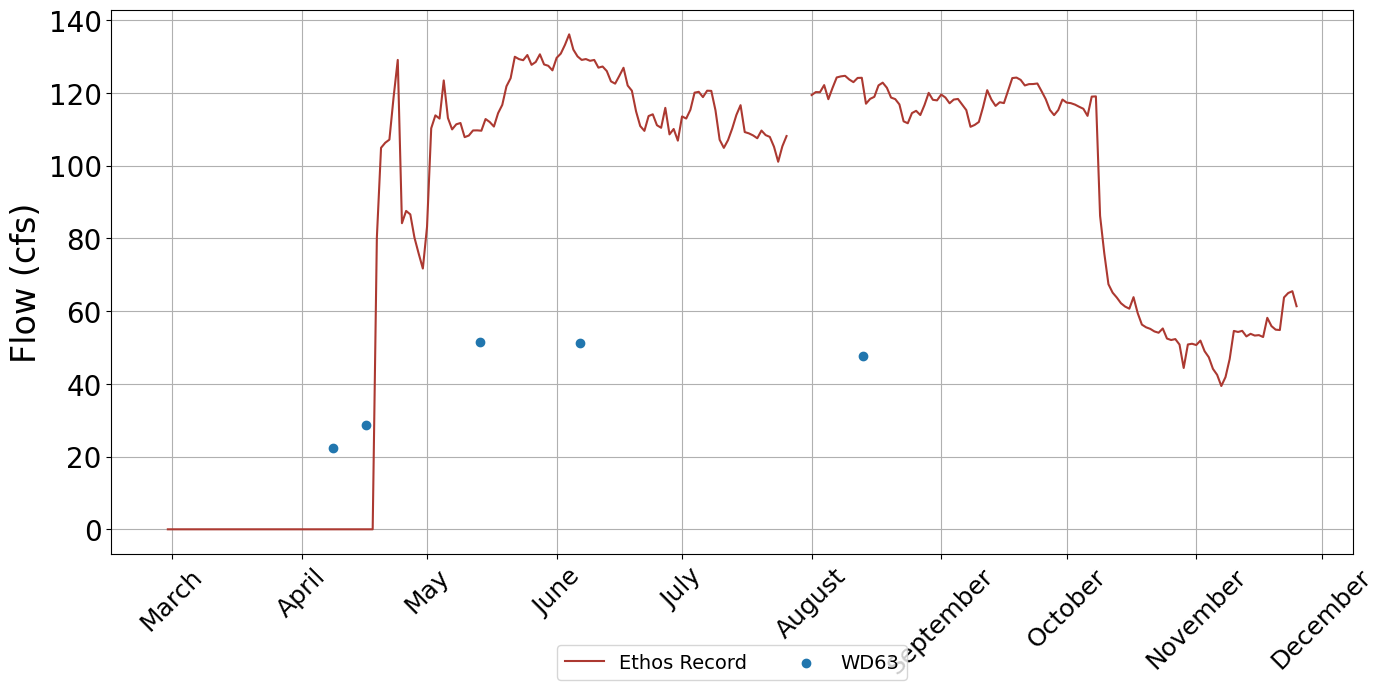

In [78]:
# COPMARISON of Actual Streamflow measurements by Daniel to Ethos record
df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/drainflow_out/final_continuous_flow.csv')

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Filter the data for 'Mason at Madison'
mason_madison_df = df[df['Gauge'] == 'Mason at Madison']

# Actual measurements for Mason at Madison
actual_measurements = {
    'Date': pd.to_datetime(['2024-04-08 13:40', '2024-04-16 10:50',
                            '2024-05-13 15:15', '2024-06-06 11:50', '2024-08-13 09:22']),
    'Flow(cfs)': [22.4, 28.7, 51.5, 51.2, 47.7]
}
actual_df = pd.DataFrame(actual_measurements)

# Plotting
plt.figure(figsize=(14, 7))

# Plot the Mason at Madison data from the file
plt.plot(mason_madison_df['Date'], mason_madison_df['Flow(cfs)'],
         label='Ethos Record', color='#AC3931', marker='o', markersize=0)

# Plot the actual field measurements
plt.scatter(actual_df['Date'], actual_df['Flow(cfs)'],
            label='WD63', color='#2176AE', zorder=5)

# Customizing the plot
plt.title('', fontsize=22)
plt.xlabel('', fontsize=20)
plt.ylabel('Flow (cfs)', fontsize=24)
plt.grid(True)

# Set x-axis major locator to show ticks at the start of every month and format to month names
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B'))

plt.xticks(fontsize=18, rotation=45)
plt.yticks(fontsize=20)

# Add legend below the plot
legend = plt.legend(title='', fontsize=14, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.setp(legend.get_title(), fontsize=18, fontweight='bold')

plt.tight_layout()

plt.show()

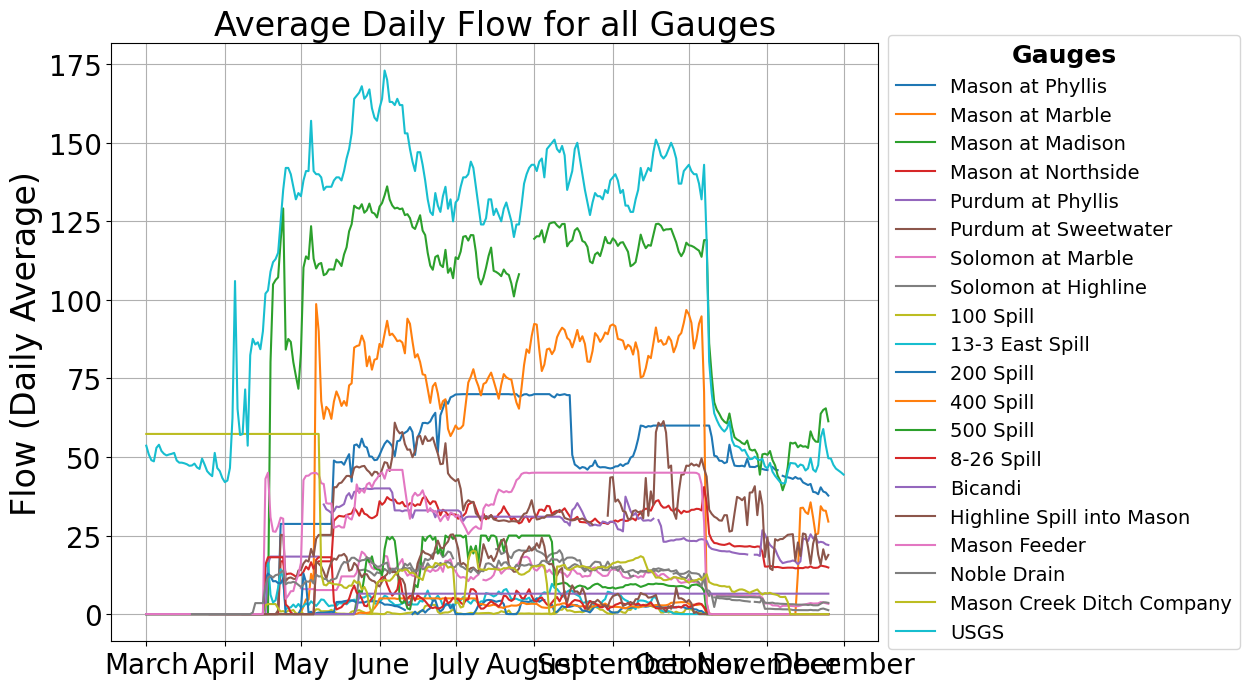

In [79]:
## ---------------------------------- ##
##  Superimposed Plot of Daily Data   ##
## ---------------------------------- ##

filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

color_palette = ['#4C934C', '#2292A4','#63264A', '#9B3D12']

plt.figure(figsize=(14, 7))

for gauge in filtered_df['Gauge'].unique():
    gauge_data = filtered_df[filtered_df['Gauge'] == gauge]
    plt.plot(gauge_data['Date'], gauge_data['Flow(cfs)'], marker='o', label=gauge, markersize=0)

plt.title('Average Daily Flow for all Gauges', fontsize = 24)
plt.xlabel('')
plt.ylabel('Flow (Daily Average)', fontsize = 24)
plt.legend()
plt.grid(True)

# Set x-axis major locator to show ticks at the start of every month and format to month names
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B'))

legend = plt.legend(title='Gauges', fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.setp(legend.get_title(), fontsize=18, fontweight='bold')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('/content/drive/MyDrive/Data/Mason Water Budget/data_output/drainflow_out/Figures/all_flow.png', dpi=300, bbox_inches='tight')
plt.show()

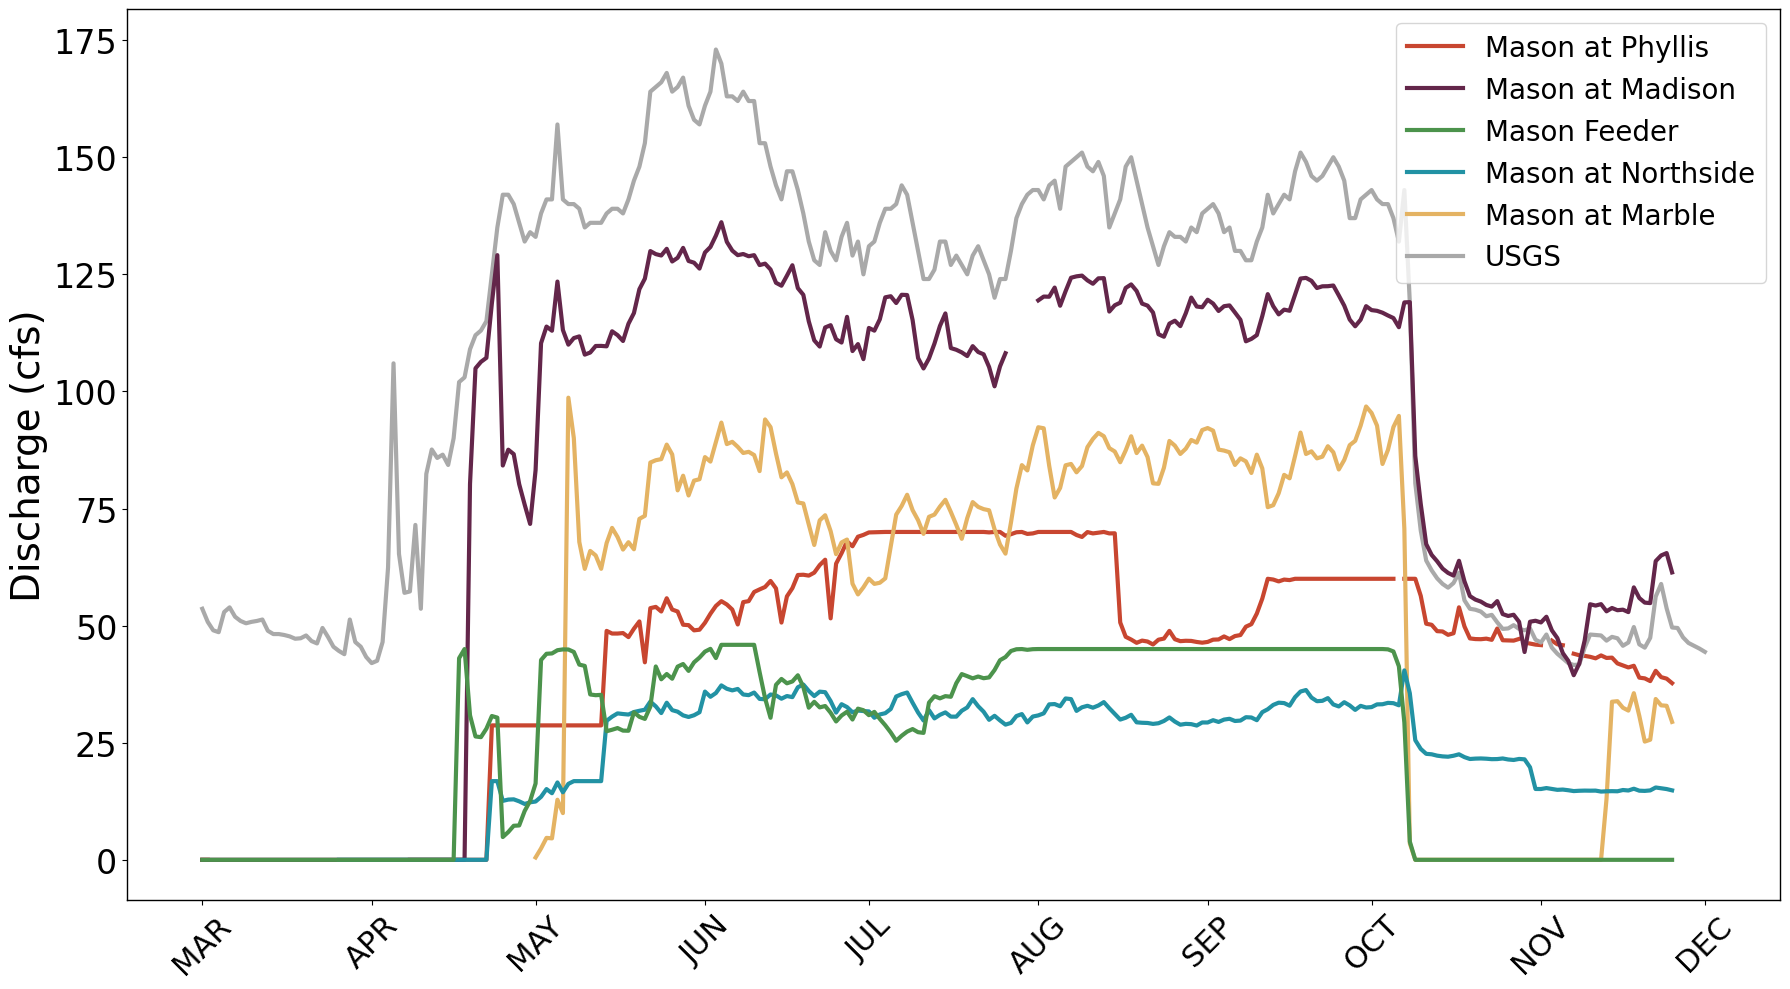

In [80]:
## ---------------------------------- ##
##  Superimposed Plot of Daily Data   ##
## ---------------------------------- ##

def theme_cust(ax):
    ax.set_facecolor('white')
    ax.grid(visible=False)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.tick_params(axis='x', colors='black', labelsize=22)
    ax.tick_params(axis='y', colors='black', labelsize=22)
    return ax
custom_palette = {
    'Mason at Phyllis': '#C84630',
    'USGS': 'darkgrey',
    'Mason at Marble': '#E4B363',
    'Mason at Madison': '#63264A',
    'Mason at Northside': '#2292A4',
    'Mason Feeder': '#4C934C'
}

selected_gauges = list(custom_palette.keys())
filtered_gauge_df = filtered_df[filtered_df['Gauge'].isin(selected_gauges)]
def custom_month_formatter(x, pos):
    return mdates.num2date(x).strftime('%b').upper()


fig, ax = plt.subplots(figsize=(18, 10))

for gauge in selected_gauges:
    gauge_data = filtered_gauge_df[filtered_gauge_df['Gauge'] == gauge]
    ax.plot(gauge_data['Date'], gauge_data['Flow(cfs)'], marker='o', markersize=0,
            linewidth=3, color=custom_palette[gauge], label=gauge)

ax.set_title('', fontsize=32, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Discharge (cfs)', fontsize=28)
theme_cust(ax)
ax.xaxis.set_major_locator(mdates.MonthLocator())

ax.xaxis.set_major_formatter(ticker.FuncFormatter(custom_month_formatter))

ax.tick_params(axis='x', labelsize=22, rotation=45)
ax.tick_params(axis='y', labelsize=24)
handles, labels = ax.get_legend_handles_labels()
legend_order = ['USGS', 'Mason at Marble', 'Mason at Northside', 'Mason Feeder','Mason at Madison', 'Mason at Phyllis'][::-1]
ordered_handles = [handles[labels.index(g)] for g in legend_order if g in labels]
legend = ax.legend(ordered_handles, legend_order, title='', fontsize=20, loc='upper right', frameon=True)
plt.setp(legend.get_title(), fontsize=22, fontweight='bold')
plt.tight_layout()

plt.tight_layout()

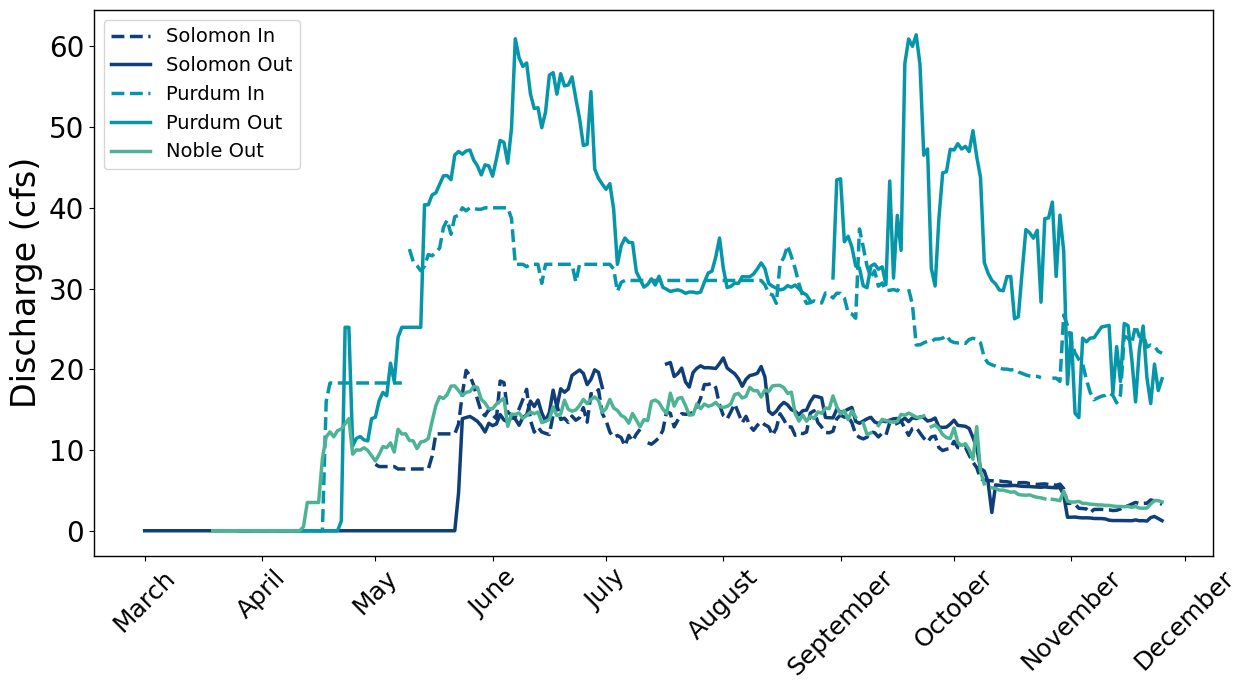

In [95]:
## ---------------------------------- ##
##  Superimposed Plot of Daily Data   ##
## ---------------------------------- ##

# SOLOMON, PURDUM, and NOBLE GAUGES ONLY

selected_gauges = ['Solomon at Marble', 'Solomon at Highline',
                   'Purdum at Phyllis', 'Purdum at Sweetwater',
                   'Noble Drain']

gauge_pairs = {
    "Solomon at Marble": "#0F3E78", "Solomon at Highline": "#0F3E78",
    "Purdum at Phyllis": "#0596A9", "Purdum at Sweetwater": "#0596A9",
    "Noble Drain": "#4CB495"
}

line_styles = {
    "Solomon at Marble": "--", "Solomon at Highline": "-",
    "Purdum at Phyllis": "--", "Purdum at Sweetwater": "-",
    "Noble Drain": "-"
}

custom_legend_labels = {
    "Solomon at Marble": "Solomon In",
    "Solomon at Highline": "Solomon Out",
    "Purdum at Phyllis": "Purdum In",
    "Purdum at Sweetwater": "Purdum Out",
    "Noble Drain": "Noble Out"
}

filtered_gauge_df = filtered_df[filtered_df['Gauge'].isin(selected_gauges)]

fig, ax = plt.subplots(figsize=(14, 7))

for gauge in selected_gauges:
    gauge_data = filtered_gauge_df[filtered_gauge_df['Gauge'] == gauge]
    ax.plot(gauge_data['Date'], gauge_data['Flow(cfs)'],
            marker='o', markersize=0, color=gauge_pairs[gauge],
            linestyle=line_styles[gauge], linewidth=2.5, label=custom_legend_labels[gauge])

theme_cust(ax)

ax.set_title('', fontsize=28, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Discharge (cfs)', fontsize=24)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
ax.tick_params(axis='x', labelsize=18, rotation=45)
ax.tick_params(axis='y', labelsize=20)

legend = ax.legend(title='', fontsize=14, loc='upper left', frameon=True)
plt.setp(legend.get_title(), fontsize=18, fontweight='bold')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

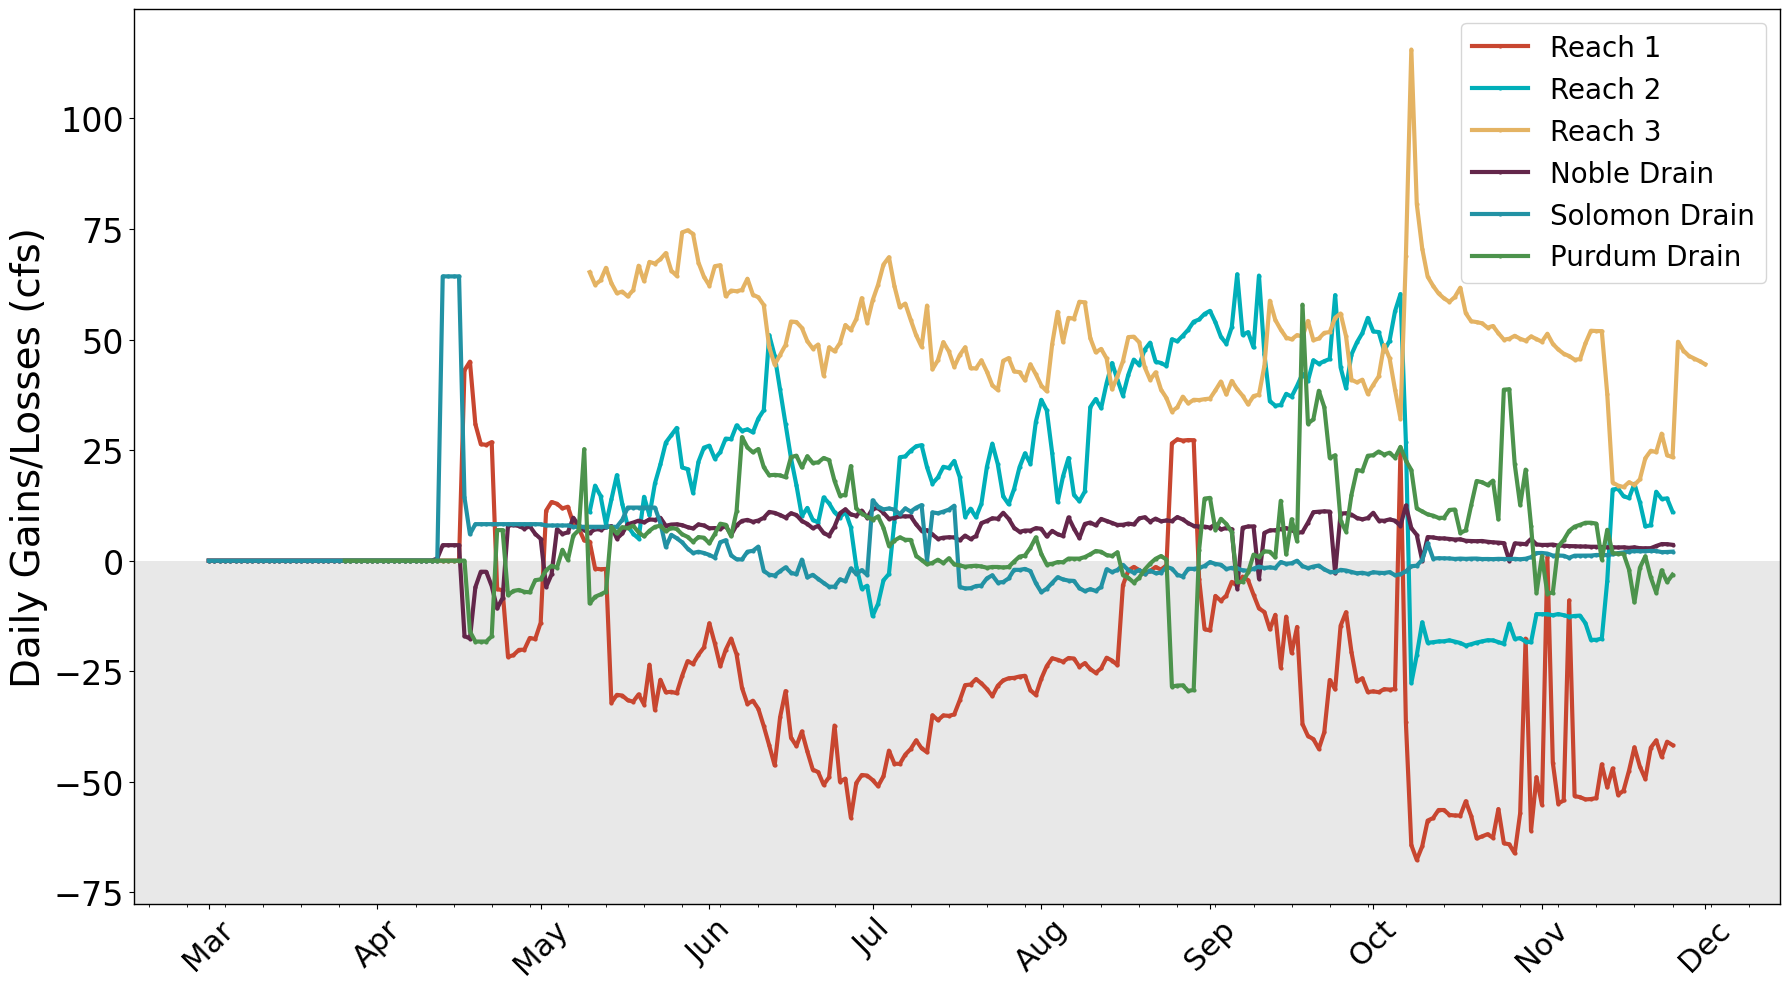

In [60]:
# -------------------------------- #
# Continuous plot of change in flow
# -------------------------------- #


df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/drainflow_out/final_continuous_flow.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'] >= '2024-03-01') & (df['Date'] <= '2024-12-31')]
final_df = pd.DataFrame()

# Define reaches and their respective inflows (Qin) and outflows (Qout)
reach_definitions = {
    "Reach 1": {
        "Qin": ["Mason at Phyllis", "Purdum at Sweetwater"],
        "Qout": ["Mason at Northside", "Mason Feeder"]
    },
    "Reach 2": {
        "Qin": ["Mason at Northside", "8-26 Spill", "Highline Spill into Mason", "100 Spill", "Noble Drain"],
        "Qout": ["Mason at Marble", "Mason Creek Ditch Company"]
    },
    "Reach 3": {
        "Qin": ["Mason at Marble", "Solomon at Marble", "400 Spill"],
        "Qout": ["Bicandi", "USGS"]
    },
    "Noble Drain": {
        "Qin": ["13-3 East Spill", "200 Spill"],
        "Qout": ["Noble Drain"]
    },
    "Solomon Drain": {
        "Qin": ["Solomon at Highline"],
        "Qout": ["Solomon at Marble"]
    },
    "Purdum Drain": {
        "Qin": ["Purdum at Phyllis"],
        "Qout": ["Purdum at Sweetwater"]
    }
}

for reach, gauges in reach_definitions.items():
    qin_dfs = []
    for gauge in gauges["Qin"]:
        qin_df = df[df["Gauge"] == gauge][["Date", "Flow(cfs)"]].rename(columns={"Flow(cfs)": f"Qin_{gauge}"})
        qin_dfs.append(qin_df)
    qin_reach = qin_dfs[0]
    for qin_df in qin_dfs[1:]:
        qin_reach = pd.merge(qin_reach, qin_df, on="Date", how="outer")
    qin_reach.fillna(0, inplace=True)
    qin_reach["Qin"] = qin_reach.loc[:, qin_reach.columns != "Date"].sum(axis=1)
    qin_reach = qin_reach[["Date", "Qin"]]
    qout_dfs = []
    for gauge in gauges["Qout"]:
        qout_df = df[df["Gauge"] == gauge][["Date", "Flow(cfs)"]].rename(columns={"Flow(cfs)": f"Qout_{gauge}"})
        qout_dfs.append(qout_df)
    qout_reach = qout_dfs[0]
    for qout_df in qout_dfs[1:]:
        qout_reach = pd.merge(qout_reach, qout_df, on="Date", how="outer")
    qout_reach.fillna(0, inplace=True)
    qout_reach["Qout"] = qout_reach.loc[:, qout_reach.columns != "Date"].sum(axis=1)
    qout_reach = qout_reach[["Date", "Qout"]]
    reach_df = pd.merge(qin_reach, qout_reach, on="Date", how="outer").fillna(0)
    reach_df["Reach"] = reach
    final_df = pd.concat([final_df, reach_df], ignore_index=True)
final_df["Reach Gains/Losses"] = final_df["Qout"] - final_df["Qin"]
final_df.fillna(0, inplace=True)

### ----------------- ###
### Plotting Results with Shaded Bottom ###
### ----------------- ###


def theme_cust(ax):
    ax.set_facecolor('white')
    ax.grid(visible=False)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.tick_params(axis='x', colors='black', labelsize=22)
    ax.tick_params(axis='y', colors='black', labelsize=22)
    return ax

custom_palette = {
    "Reach 1": "#C84630",
    "Reach 2": "#00AFB9",
    "Reach 3": "#E4B363",
    "Noble Drain": "#63264A",
    "Solomon Drain": "#2292A4",
    "Purdum Drain": "#4C934C"
}

fig, ax = plt.subplots(figsize=(18, 10))

for reach in final_df["Reach"].unique():
    reach_data = final_df[final_df["Reach"] == reach]
    if reach in ["Reach 2", "Reach 3"]:
        reach_data = reach_data[reach_data["Date"] >= "2024-05-10"]
    ax.plot(reach_data["Date"], reach_data["Reach Gains/Losses"], marker='o', markersize=2,
            linewidth=3, color=custom_palette.get(reach, "#000000"), label=reach)

ax.set_ylim(bottom=final_df["Reach Gains/Losses"].min() - 10)
ax.axhspan(ymin=ax.get_ylim()[0], ymax=0, facecolor='lightgrey', alpha=0.5)

ax.set_title("", fontsize=32, fontweight="bold")
ax.set_xlabel("")
ax.set_ylabel("Daily Gains/Losses (cfs)", fontsize=28)
theme_cust(ax)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

ax.tick_params(axis="x", labelsize=22, rotation=45)
ax.tick_params(axis="y", labelsize=24)
ax.legend(title="", fontsize=20, loc="upper right", frameon=True)

plt.tight_layout()
plt.show()

## Calculate Cumulative Monthly Discharge & Define Inflows / Outflows

In [96]:
# ----------------------------------------------- #
# Calculate the total volume of monthly flow (AF)
# ----------------------------------------------- #

df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/drainflow_out/final_continuous_flow.csv')

# Convert 'Date' to datetime and keep necessary columns
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df[['Gauge', 'Date', 'Flow(cfs)']].dropna(subset=['Date', 'Flow(cfs)'])  # Drop rows with NaN in Date or Flow(cfs)

# Ensure 'Flow(cfs)' is numeric
df['Flow(cfs)'] = pd.to_numeric(df['Flow(cfs)'], errors='coerce')
df = df.dropna(subset=['Flow(cfs)'])  # Drop rows with NaN in Flow(cfs) after conversion

# Initialize list to store monthly cumulative flows for each gauge
monthly_cumulative_flow = []

# Group by 'Gauge' and process each gauge's data separately
for gauge, gauge_data in df.groupby('Gauge'):
    # Sort data by 'Date', set 'Date' as index, and keep only 'Flow(cfs)' column
    gauge_data = gauge_data.sort_values(by='Date').set_index('Date')[['Flow(cfs)']]

    # Resample to daily frequency and calculate daily volume
    gauge_daily = gauge_data.resample('D').mean()
    gauge_daily['Daily_Volume'] = gauge_daily['Flow(cfs)'] * 86400  # Convert flow to daily volume in cubic feet

    # Fill any NaN in 'Daily_Volume' after resampling with 0
    gauge_daily['Daily_Volume'].fillna(0, inplace=True)

    # Resample to get monthly cumulative volume in acre-feet
    gauge_monthly = gauge_daily['Daily_Volume'].resample('M').sum() / 43560  # Convert to acre-feet

    # Create DataFrame for this gauge's monthly data
    gauge_monthly_df = pd.DataFrame({
        'Gauge': gauge,
        'Month': gauge_monthly.index,
        'Cumulative Flow (AF)': gauge_monthly.values
    })

    # Append to the list
    monthly_cumulative_flow.append(gauge_monthly_df)

monthly_df = pd.concat(monthly_cumulative_flow, ignore_index=True)
monthly_df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/drainflow_out/monthly_flow.csv', index=False)

<ipython-input-96-792949f91476>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gauge_daily['Daily_Volume'].fillna(0, inplace=True)
<ipython-input-96-792949f91476>:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gauge_monthly = gauge_daily['Daily_Volume'].resample('M').sum() / 43560  # Convert to acre-feet
<ipython-input-96-792949f91476>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.

In [97]:
# --------------------------------- #
# Calculate Reach Inflows & Outflows
# --------------------------------- #

df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/drainflow_out/monthly_flow.csv')
df['Month'] = pd.to_datetime(df['Month']).dt.to_period('M').dt.strftime('%Y-%m') # convert 'Month' column to datetime

final_df = pd.DataFrame()


# ------ #
# Reach 1
# ------ #
qin_r1_phyllis = df[df['Gauge'] == "Mason at Phyllis"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qin_Phyllis'})
qin_r1_purdum = df[df['Gauge'] == "Purdum at Sweetwater"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qin_Purdum'})
qout_r1_northside = df[df['Gauge'] == "Mason at Northside"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qout_Northside'})
qout_r1_feeder = df[df['Gauge'] == "Mason Feeder"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qout_Feeder'})

# Qin
qin_r1 = pd.merge(qin_r1_phyllis, qin_r1_purdum, on='Month', how='inner')
qin_r1['Qin'] = qin_r1['Qin_Phyllis'] + qin_r1['Qin_Purdum']
qin_r1 = qin_r1[['Month', 'Qin']]

# Qout
qout_r1 = pd.merge(qout_r1_northside, qout_r1_feeder, on='Month', how='inner')
qout_r1['Qout'] = qout_r1['Qout_Northside'] + qout_r1['Qout_Feeder'] #MASON FEEDER ADDED TO MASON AT NORTHSIDE
qout_r1 = qout_r1[['Month', 'Qout']]

# Merge Qin and Qout
reach_1_df = pd.merge(qin_r1, qout_r1, on='Month', how='inner')
reach_1_df.insert(0, 'Reach', 'Reach 1')
final_df = pd.concat([final_df, reach_1_df], ignore_index=True)

# ------ #
# Reach 2
# ------ #
# Define Qin gauges for Reach 2
qin_r2_northside = df[df['Gauge'] == "Mason at Northside"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qin_Northside'})
qin_r2_8_26_spill = df[df['Gauge'] == "8-26 Spill"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qin_8_26_Spill'})
qin_r2_high_line_spill = df[df['Gauge'] == "Highline Spill into Mason"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qin_High_Line_Spill'})
qin_r2_100_spill = df[df['Gauge'] == "100 Spill"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qin_100_Spill'})
qin_r2_noble_drain = df[df['Gauge'] == "Noble Drain"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qin_Noble_Drain'})
qout_r2_mason_feeder = df[df['Gauge'] == "Mason Feeder"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qout_Mason_Feeder'})

# Qin
qin_r2 = pd.merge(qin_r2_northside, qin_r2_8_26_spill, on='Month', how='inner')
qin_r2 = pd.merge(qin_r2, qin_r2_high_line_spill, on='Month', how='inner')
qin_r2 = pd.merge(qin_r2, qin_r2_100_spill, on='Month', how='inner')
qin_r2 = pd.merge(qin_r2, qin_r2_noble_drain, on='Month', how='inner')
qin_r2 = pd.merge(qin_r2,qout_r2_mason_feeder,on='Month', how='inner')

qin_r2['Qin'] = qin_r2['Qin_Northside'] + qin_r2['Qin_8_26_Spill'] + qin_r2['Qin_High_Line_Spill'] + qin_r2['Qin_100_Spill'] + qin_r2['Qin_Noble_Drain']
qin_r2 = qin_r2[['Month', 'Qin']]

# Qout
qout_r2_marble_front = df[df['Gauge'] == "Mason at Marble"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qout_Marble_Front'})
qout_r2_mason_creek_ditch = df[df['Gauge'] == "Mason Creek Ditch Company"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qout_Mason_Creek_Ditch'})

# Merge Qout components
qout_r2 = pd.merge(qout_r2_marble_front, qout_r2_mason_creek_ditch, on='Month', how='inner')

# Calculate total Qout
qout_r2['Qout'] = qout_r2['Qout_Marble_Front'] + qout_r2['Qout_Mason_Creek_Ditch']
qout_r2 = qout_r2[['Month', 'Qout']]

# Merge Qin and Qout
reach_2_df = pd.merge(qin_r2, qout_r2, on='Month', how='inner')
reach_2_df.insert(0, 'Reach', 'Reach 2')
final_df = pd.concat([final_df, reach_2_df], ignore_index=True)

# ------ #
# Reach 3
# ------ #
qin_r3_marble = df[df['Gauge'] == "Mason at Marble"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qin_Marble'})
qin_r3_solomon = df[df['Gauge'] == "Solomon at Marble"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qin_Solomon'})
qin_r3_400_spill = df[df['Gauge'] == "400 Spill"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qin_400_Spill'})

# Qin
qin_r3 = qin_r3_marble
qin_r3 = pd.merge(qin_r3, qin_r3_solomon, on='Month', how='inner')
qin_r3 = pd.merge(qin_r3, qin_r3_400_spill, on='Month', how='inner')

qin_r3['Qin'] = qin_r3[['Qin_Marble', 'Qin_Solomon', 'Qin_400_Spill']].sum(axis=1)
qin_r3 = qin_r3[['Month', 'Qin']]

# Qout
qout_r3_bicandi = df[df['Gauge'] == "Bicandi"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qout_Bicandi'})
qout_r3_usgs = df[df['Gauge'] == "USGS"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qout_USGS'})

qout_r3 = pd.merge(qout_r3_bicandi, qout_r3_usgs, on='Month', how='inner')

qout_r3['Qout'] = qout_r3[['Qout_Bicandi', 'Qout_USGS']].sum(axis=1)
qout_r3 = qout_r3[['Month', 'Qout']]

# Merge Qin and Qout
reach_3_df = pd.merge(qin_r3, qout_r3, on='Month', how='inner')
reach_3_df.insert(0, 'Reach', 'Reach 3')
final_df = pd.concat([final_df, reach_3_df], ignore_index=True)


# ------------ #
# Solomon Reach
# ------------ #

#Qin
qin_solomon = df[df['Gauge'] == "Solomon at Highline"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qin'})

#Qout
qout_solomon = df[df['Gauge'] == "Solomon at Marble"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qout'})

# Merge Qin and Qout
solomon_reach_df = pd.merge(qin_solomon, qout_solomon, on='Month', how='inner')
solomon_reach_df.insert(0, 'Reach', 'Solomon Reach')
final_df = pd.concat([final_df, solomon_reach_df], ignore_index=True)

# ------------ #
# Purdum Reach
# ------------ #

# Qin
qin_purdum = df[df['Gauge'] == "Purdum at Phyllis"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qin'})

# Qout
qout_purdum = df[df['Gauge'] == "Purdum at Sweetwater"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qout'})

# Merge Qin and Qout
purdum_reach_df = pd.merge(qin_purdum, qout_purdum, on='Month', how='inner')
purdum_reach_df.insert(0, 'Reach', 'Purdum Reach')
final_df = pd.concat([final_df, purdum_reach_df], ignore_index=True)


# ------------ #
# Noble Reach
# ------------ #

qin_noble_13_3 = df[df['Gauge'] == "13-3 East Spill"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qin_13_3'})
qin_noble_200 = df[df['Gauge'] == "200 Spill"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qin_noble_200'})

# Qin
qin_noble = pd.merge(qin_noble_13_3, qin_noble_200 , on='Month', how='inner')
qin_noble['Qin'] = qin_noble['Qin_13_3'] + qin_noble['Qin_noble_200']
qin_noble = qin_noble[['Month', 'Qin']]

# Qout
qout_noble = df[df['Gauge'] == "Noble Drain"][['Month', 'Cumulative Flow (AF)']].rename(columns={'Cumulative Flow (AF)': 'Qout'})

noble_reach_df = pd.merge(qin_noble, qout_noble, on='Month', how='inner')
noble_reach_df.insert(0, 'Reach', 'Noble Reach')
final_df = pd.concat([final_df, noble_reach_df], ignore_index=True)

final_df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/drainflow_out/final_monthly_flow.csv', index=False)

## Plot of Change in Flow

In [100]:
## --------------- ##
## IMPORT PACKAGES ##
## --------------- ##

import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
# ---------------------------- #
# Calculate Reach Gains/Losses
# --------------------------- #
def calculate_flow_difference(df):
    """
    Calculate the flow difference (Qout - Qin) in acre-feet (AF) for each Gauge at each Month.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'Gauge', 'Month', 'Qin', and 'Qout' columns.

    Returns:
    pd.DataFrame: DataFrame with an additional 'Flow Difference (AF)' column.
    """
    df['Qin'] = pd.to_numeric(df['Qin'], errors='coerce')
    df['Qout'] = pd.to_numeric(df['Qout'], errors='coerce')
    df['Flow Difference (AF)'] = df['Qout'] - df['Qin']

    return df
final_df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/drainflow_out/final_monthly_flow.csv')

# Calculate the Flow Difference
final_df_with_difference = calculate_flow_difference(final_df)
final_df_with_difference['Month'] = pd.PeriodIndex(final_df_with_difference['Month'], freq='M').astype(str)

# convert from AF to KAF
final_df_with_difference['Flow Difference (KAF)'] = final_df_with_difference['Flow Difference (AF)'] / 1000
final_df_with_difference.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/drainflow_out/reach_final_monthly_flow.csv', index=False)

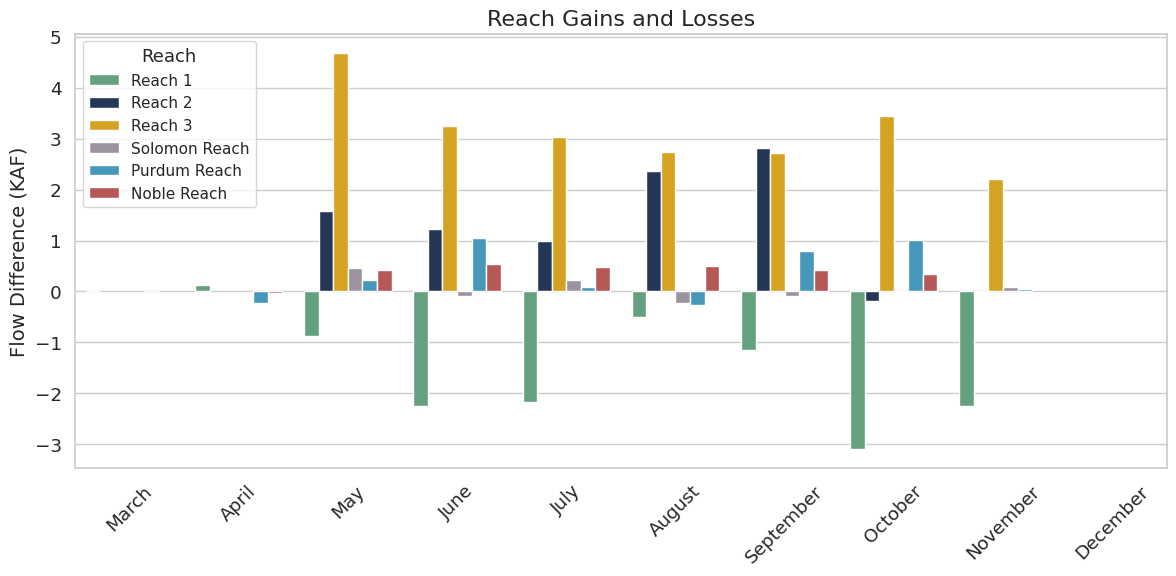

In [102]:
# ------------------------- #
# Plot of Reach Gains/Losses
# ------------------------- #

final_df_with_difference['Month'] = pd.to_datetime(final_df_with_difference['Month'], format='%Y-%m')
final_df_with_difference['Month'] = final_df_with_difference['Month'].dt.strftime('%B')  # Convert to month names

# filter out January and February
final_df_with_difference = final_df_with_difference[~final_df_with_difference['Month'].isin(['January', 'February'])]

sns.set(style="whitegrid", font_scale=1.2)

custom_palette = {
    "Reach 1": "#5CAB7D",
    "Reach 2": "#1D3461",
    "Reach 3": "#F3AF04",
    "Purdum Reach": "#32A0CF",
    "Solomon Reach": "#9D91A3",
    "Noble Reach": '#C64846'
}


plt.figure(figsize=(12, 6))
sns.barplot(
    data=final_df_with_difference,
    x='Month', y='Flow Difference (KAF)', hue='Reach',
    palette=custom_palette,
    order=['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
)

plt.title("Reach Gains and Losses", fontsize=16)
plt.xlabel("")
plt.ylabel("Flow Difference (KAF)", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Reach", title_fontsize='13', fontsize='11')
plt.tight_layout()
plt.show()
plt.savefig('/content/drive/MyDrive/Data/Mason Water Budget/data_output/drainflow_out/Figures/reach_gainslosses.png', dpi=300, bbox_inches='tight')
plt.close()

## Mason Drainage Water Budget

In [ ]:
## --------------- ##
## IMPORT PACKAGES ##
## --------------- ##

import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [103]:
# --------------------------------------- #
# Inflows and Outflows for Mason Drainage
# --------------------------------------- #

df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/drainflow_out/monthly_flow.csv')

# Convert 'Month' column to datetime format
df['Month'] = pd.to_datetime(df['Month']).dt.to_period('M').dt.strftime('%Y-%m')

# List of inflow and outflow gauges
inflow_gauges = ["Mason at Phyllis", "Purdum at Sweetwater", "8-26 Spill",
                 "Highline Spill into Mason", "100 Spill", "Noble Drain",
                 "Solomon at Marble", "400 Spill"]

outflow_gauges = ["Mason Feeder", "Bicandi", "USGS","Mason Creek Ditch Company"]

# Summing inflows
inflow_df = df[df['Gauge'].isin(inflow_gauges)]
monthly_inflow = inflow_df.groupby('Month')['Cumulative Flow (AF)'].sum().reset_index()
monthly_inflow.rename(columns={'Cumulative Flow (AF)': 'Inflow (AF)'}, inplace=True)

# Summing outflows
outflow_df = df[df['Gauge'].isin(outflow_gauges)]
monthly_outflow = outflow_df.groupby('Month')['Cumulative Flow (AF)'].sum().reset_index()
monthly_outflow.rename(columns={'Cumulative Flow (AF)': 'Outflow (AF)'}, inplace=True)

# Merging inflow and outflow data
mason_df = pd.merge(monthly_inflow, monthly_outflow, on='Month', how='outer').fillna(0)
mason_df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/drainflow_out/mason_final_monthly_flow.csv')